In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate
from src.interpolate import *
import jax

from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
from pyfftw.builders import irfft2

Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

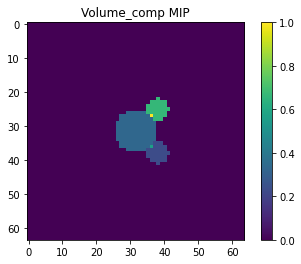

In [3]:
nx = 64
shape = np.array([nx,nx,nx])
dimensions = np.array([20,20,20])
pixel_size = dimensions[0]/shape[0]

# A volume with components
centres = np.array([[0,0,0], [2, 2, 0], [2, -2, 0]])
radii = np.array([2, 1, 1])
intensities = np.array([10,7,20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False))
vol_fourier, X, Y, Z = volume_fourier(jnp.fft.ifftshift(vol), pixel_size)

mip_z(vol)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

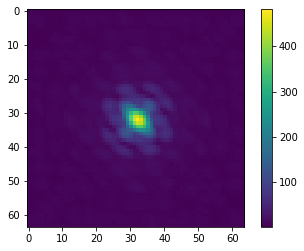

In [4]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()

Get the grids and mask

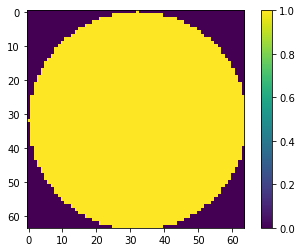

In [5]:
x_freq = X[0,:,0]
y_freq = Y[:,0,0]
z_freq = Z[0,0,:]

# Important thast the grids are not jax (aka Tracer)  objects
x_grid = np.array([x_freq[1], len(x_freq)])
y_grid = np.array([y_freq[1], len(y_freq)])
z_grid = np.array([z_freq[1], len(z_freq)])

radius = 1.6
mask = create_mask(X, Y, Z , (0,0,0),radius)

shifts0 = jnp.array([0,0])

mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

CTF

In [6]:
df = star.parse_star("../external/pyem/pyem.star", keep_index = False)
dfiter = df.iterrows()
_, p = next(dfiter)

ctf_params = {'def1'  : p[star.Relion.DEFOCUSU], 
              'def2'  : p[star.Relion.DEFOCUSV],
              'angast': p[star.Relion.DEFOCUSANGLE], 
              'phase' : p[star.Relion.PHASESHIFT],
              'kv'    : p[star.Relion.VOLTAGE],
              'ac'    : p[star.Relion.AC], 
              'cs'    : p[star.Relion.CS], 
              'bf'    : 0,
              'lp'    : 2 * pixel_size}

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:532: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_NAME].str.split("@").str
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:540: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_ORIGINAL_NAME].str.split("@").str


Generate projections (in Fourier domain)

In [7]:
@jax.jit
def slice_func(v, angles):
    projection, _ = project(v, x_grid, y_grid, z_grid, angles, shifts0, "tri", ctf_params)
    #projection, _ = project(v, x_grid, y_grid, z_grid, angles)

    return projection

@jax.jit
def slice_func_array(v, angles):    
    return jax.vmap(slice_func, in_axes = (None, 0))(v, angles)

In [8]:
img0 = slice_func(vol_fourier, [0,0,0])

N = 20000
angles_true = jnp.array(np.random.rand(N,3))*jnp.pi*2
start = time.time()
imgs = slice_func_array(vol_fourier, angles_true) + (np.random.randn(N, nx*nx) + 1j*np.random.randn(N, nx*nx)) * jnp.max(img0)
print(time.time()-start)

8.765600681304932


In [9]:
imgs.shape

(20000, 4096)

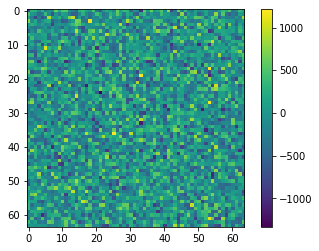

In [10]:
plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

In [11]:
np.sum(mask[0])

DeviceArray(3207., dtype=float64)

Loss function given volume and angles, for one image and for many (batches of images). We have a separate loss function for each angles-image pair.

In [12]:
@jax.jit
def l2sq(x):
    return jnp.real(jnp.sum(jnp.conj(x)*x))

@jax.jit
def loss_func(v, angles, img, alpha = 0.01):
    #return 1/(2* nx*nx) * l2sq(slice_func(v, angles) - img)
    #return 1/(2* 1257) * l2sq(slice_func(v, angles) - img)   #1257 = number of pixels in mask at z=0
    
    # With l2 regularization
    return 1/(2* nx*nx) * (alpha * l2sq(v) + l2sq(slice_func(v, angles) - img))



@jax.jit
def loss_func_batched(v, angles, imgs):
    return jax.vmap(loss_func, in_axes = (None, 0, 0))(v, angles, imgs)

@jax.jit
def loss_func_sum(v, angles, imgs):
    return jnp.mean(loss_func_batched(v, angles, imgs))

In [13]:
loss_func(vol_fourier, angles_true[0],imgs[0])

DeviceArray(132196.97047919, dtype=float64)

And the gradients of the above, with respect to angles

In [14]:
@jax.jit
def grad_loss_angles(v, angles, img):
    return jax.grad(loss_func, argnums = 1)(v, angles, img)

@jax.jit
def grad_loss_angles_batched(v, angles, imgs):
    return jax.vmap(grad_loss_angles, in_axes = (None, 0, 0))(v, angles, imgs)

In [15]:
start = time.time()
ll = loss_func_batched(vol_fourier, angles_true, imgs)
print(time.time()-start)
print(ll.shape)

1.1496834754943848
(20000,)


In [16]:
start = time.time()
dl = grad_loss_angles(vol_fourier, angles_true[0], imgs[0])
print(time.time()-start)
print(dl.shape)

2.016355514526367
(3,)


In [17]:
#start = time.time()
#dl = grad_loss_angles_batched(vol_fourier, angles_true, imgs)
#print(time.time()-start)
#print(dl.shape)

Gradients with respect to volume pixels, over all (or a batch of) images

In [18]:
@jax.jit
def grad_loss_volume(v, angles, img):
    return jax.grad(loss_func)(v, angles, img)

@jax.jit
def grad_loss_volume_batched(v, angles, imgs):
    return 1/N * jnp.sum(jax.vmap(grad_loss_volume, in_axes = (None, 0, 0))(v, angles, imgs), axis=0)

@jax.jit
def grad_loss_volume_sum(v, angles, imgs):
    return jax.grad(loss_func_sum)(v, angles, imgs)


In [19]:
start = time.time()
ll = grad_loss_volume(vol_fourier, angles_true[0], imgs[0])
print(time.time()-start)
print(ll.shape)

1.0561277866363525
(64, 64, 64)


Doing the below with N large enough (e.g. 1000) makes it run out of memory (trying to allocate >200GB)

In [20]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(vol_fourier, angles_true[idx], imgs[idx])
print(time.time()-start)
print(ll.shape)

1.7970919609069824
(64, 64, 64)


## Gradient descent with respect to angles

In [21]:
alpha = 0.00000001
a = jnp.array(np.random.rand(N, 3)*np.pi*2)
a = jnp.mod(a, 2*jnp.pi)
#a = angles_true + 0.01*a
N_iter = 1

for i in range(N_iter):
        
    if jnp.mod(i,100) == 0:
    #print(i)
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(vol_fourier, a, imgs))))
        
    a = a - alpha * jnp.conj(grad_loss_angles_batched(vol_fourier, a, imgs))
    
a = jnp.mod(a, 2*jnp.pi)


    
max_err = jnp.mean(jnp.abs(a - angles_true))
print("mean(a-a_true) = " + str(max_err))

Iter 0: mean loss = 135402.12183638805
mean(a-a_true) = 2.0923257012277614


In [22]:
max_err = jnp.max(jnp.abs(a - angles_true))
print("max(a-a_true) = " + str(max_err))

max(a-a_true) = 6.240696739836626


## Optimization with respect to volume

### CG

In [23]:
from src.algorithm import conjugate_gradient

v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
N_iter = 200
zero = jnp.zeros(vol_fourier.shape).astype(jnp.complex128)
Ab = - jnp.conj(grad_loss_volume_sum(zero, angles_true, imgs))
AA = lambda vv : jnp.conj(grad_loss_volume_sum(vv, angles_true, imgs)) + Ab

vcg, max_iter = conjugate_gradient(AA, Ab, v0, N_iter, verbose = True)


Iter 0 ||r|| = 0.06632883003418112
Iter 1 ||r|| = 0.030530613212836462
Iter 2 ||r|| = 0.021057308028257327
Iter 3 ||r|| = 0.01690841984493879
Iter 4 ||r|| = 0.0121519225920193
Iter 5 ||r|| = 0.006484496840049605
Iter 6 ||r|| = 0.0032604651947674202
Iter 7 ||r|| = 0.0022746847871910744
Iter 8 ||r|| = 0.0014059653867525882
Iter 9 ||r|| = 0.0010217791003814354
Iter 10 ||r|| = 0.0006808948388908281
Iter 11 ||r|| = 0.0003554464936647346
Iter 12 ||r|| = 0.00025866318685639273
Iter 13 ||r|| = 0.00013104159139615086
Iter 14 ||r|| = 9.708993573934222e-05
Iter 15 ||r|| = 5.421437457179709e-05
Iter 16 ||r|| = 3.150060354956318e-05
Iter 17 ||r|| = 2.085434735827727e-05
Iter 18 ||r|| = 1.1258972369963368e-05
Iter 19 ||r|| = 6.404373719056827e-06
Iter 20 ||r|| = 4.2185234978234e-06
Iter 21 ||r|| = 3.383205950975069e-06
Iter 22 ||r|| = 2.2932280091035593e-06
Iter 23 ||r|| = 1.1318205772542201e-06
Iter 24 ||r|| = 5.982159158965815e-07
Iter 25 ||r|| = 4.349843283097173e-07
Iter 26 ||r|| = 2.44087913084

In [24]:
jnp.max(jnp.abs(imgs))

DeviceArray(2135.23085714, dtype=float64)

Final loss function =  135192.2072875991
Relative error =  0.26168706165914696
Absolute error =  8.693089747659227


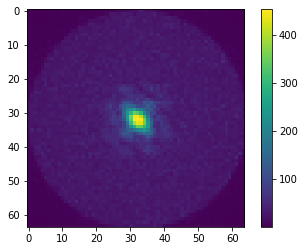

In [25]:
print("Final loss function = ", loss_func_sum(vcg, angles_true, imgs))
print("Relative error = ", jnp.max(jnp.abs((vcg - vol_fourier)/jnp.max(vol_fourier))))
print("Absolute error = ", jnp.mean(jnp.abs((vcg - vol_fourier))))


mip_z(jnp.abs(jnp.fft.fftshift((vcg)))) ; plt.colorbar()

In [26]:
l = loss_func_batched(vcg, angles_true, imgs)

In [27]:
s0 = slice_func(vcg, angles_true[709])

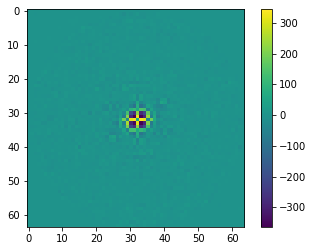

In [28]:
plt.imshow(jnp.fft.fftshift(jnp.real(s0).reshape(nx,nx))); plt.colorbar()

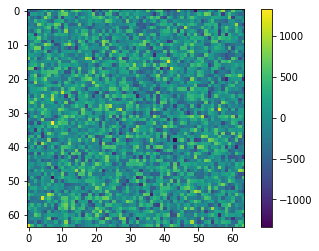

In [29]:
plt.imshow(jnp.fft.fftshift(jnp.real(imgs[709]).reshape(nx,nx))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

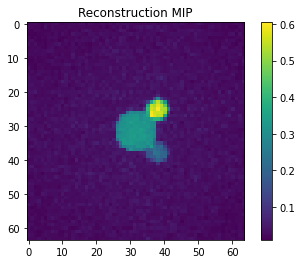

In [30]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg))))
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

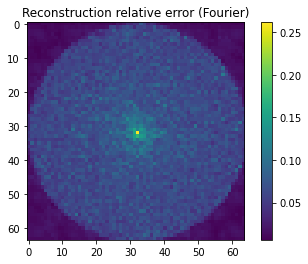

In [31]:
mip_z(jnp.abs(jnp.fft.fftshift((vcg-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

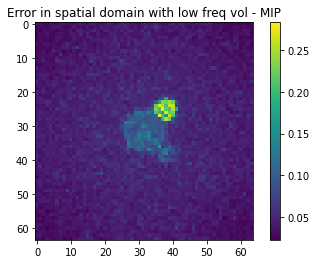

In [32]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier*mask - vcg)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

### SGD

In [33]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
#v0 = vol_fourier + 0.1*v * mask
#alpha = 1000000 # this alpha works well for full 128 x 128 x 128 volume with mask
alpha = 10000000
batch_size = 2
N_iter = 1000 * 20 
#N_iter = 1000 

v = v0
for i in range(N_iter):
    
    idx = np.random.default_rng().choice(N, size=batch_size, replace = False)
    
    if jnp.mod(i,100) == 0:
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(v, angles_true[idx], imgs[idx]))))

    v = v - alpha * jnp.conj(grad_loss_volume_batched(v, angles_true[idx], imgs[idx]))
    
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

Iter 0: mean loss = 137259.89710598037
Iter 100: mean loss = 136832.86761221167
Iter 200: mean loss = 136587.11115735007
Iter 300: mean loss = 136642.22611200198
Iter 400: mean loss = 136600.55047696823
Iter 500: mean loss = 134951.19244698022
Iter 600: mean loss = 135016.75238256552
Iter 700: mean loss = 136887.81553975452
Iter 800: mean loss = 135613.7314568797
Iter 900: mean loss = 137337.24505984277
Iter 1000: mean loss = 135978.6969642592
Iter 1100: mean loss = 133883.27168502333
Iter 1200: mean loss = 136582.4327082921
Iter 1300: mean loss = 135504.33724652126
Iter 1400: mean loss = 137676.7261361282
Iter 1500: mean loss = 133199.9793759783
Iter 1600: mean loss = 134271.67883682443
Iter 1700: mean loss = 133824.42769716607
Iter 1800: mean loss = 135417.51468474203
Iter 1900: mean loss = 133945.11362427508
Iter 2000: mean loss = 136504.9867827699
Iter 2100: mean loss = 136925.49828822922
Iter 2200: mean loss = 137132.41482205963
Iter 2300: mean loss = 135645.0496734567
Iter 2400: 

In [34]:
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

Final loss function (over all data) =  136155.0608669837
Relative error =  0.6031093281186312


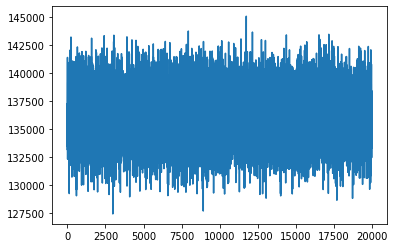

In [35]:
loss_imgs = loss_func_batched(v, angles_true, imgs)
plt.plot(loss_imgs)

Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

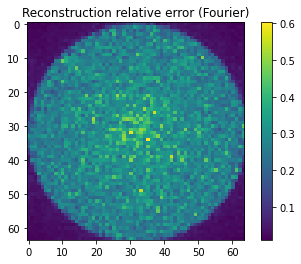

In [36]:
mip_z(jnp.abs(jnp.fft.fftshift((v-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Reconstruction MIP')

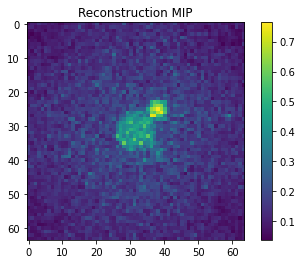

In [37]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v))))
plt.colorbar()
plt.title('Reconstruction MIP')

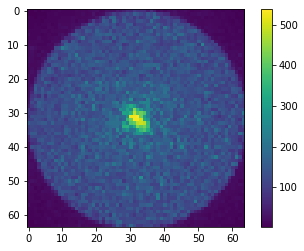

In [38]:
mip_z(jnp.abs(jnp.fft.fftshift((v)))) ; plt.colorbar()

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

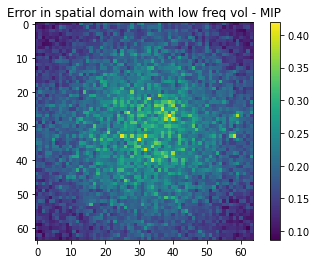

In [39]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier*mask - v*mask)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

And the error with the high freq volume

Text(0.5, 1.0, 'Reconstruction error with high freq vol -  MIP')

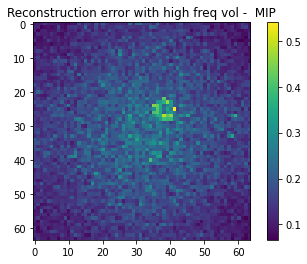

In [40]:
mip_z(jnp.abs(vol-jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')

Text(0.5, 1.0, 'Reconstruction error with high freq vol -  MIP')

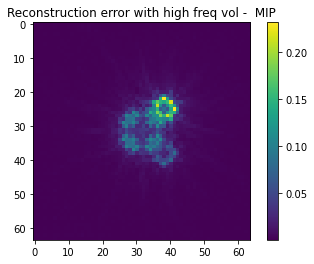

In [41]:
mip_z(jnp.abs(vol-jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier*mask)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')